# Statistical Modelling

- I will use a hierarchical bayesian linear model like Twieki uses here: https://github.com/github/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb 

In [1]:
import theano

In [2]:
theano.config.device

'cpu'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [4]:
sns.set_style('whitegrid')

In [5]:
## load the data
df_cases = pd.read_pickle('./corona_scotland_regions_ts.pk')
df_total = pd.read_pickle('./corona_scotland_total_stats.pk')

In [6]:
max_num_days = len(df_cases)
max_num_days

58

In [7]:
df_cases.columns

Index(['Ayrshire and Arran', 'Borders', 'Dumfries and Galloway',
       'Eileanan Siar (Western Isles)', 'Fife', 'Forth Valley', 'Grampian',
       'Greater Glasgow and Clyde', 'Highland', 'Lanarkshire', 'Lothian',
       'Orkney', 'Shetland', 'Tayside', 'Scotland (Total)'],
      dtype='object', name='Health Board')

In [8]:
## remove cases where there are hardly any cases
#drop_cols = df_cases.columns[df_cases.quantile(0.5) == 0.0]
drop_cols = ['Eileanan Siar (Western Isles)', 'Orkney']
print(drop_cols)

df_cases = df_cases.drop(columns=drop_cols)

['Eileanan Siar (Western Isles)', 'Orkney']


In [9]:
regions = df_cases.columns.values[:-1]
n_regions = len(regions)

In [10]:
np.argwhere(df_cases[regions[0]].gt(10).values).ravel()[0]

13

In [11]:
## find starting days
min_cases = 10
starting_days = {r: np.argwhere(df_cases[r].ge(min_cases).values).ravel()[0] for r in regions}
starting_days

{'Ayrshire and Arran': 13,
 'Borders': 15,
 'Dumfries and Galloway': 14,
 'Fife': 14,
 'Forth Valley': 9,
 'Grampian': 7,
 'Greater Glasgow and Clyde': 6,
 'Highland': 17,
 'Lanarkshire': 8,
 'Lothian': 6,
 'Shetland': 8,
 'Tayside': 8}

In [12]:
def doubling_time(r):
    i = 0
    while True:
        x = (1 + r)**i
        if x >= 2:
            break
        else:
            i += 1
    return i, x

In [13]:
rates = [0.33, 0.25, 0.2, 0.17, 0.15, 0.12, 0.10, 0.08, 0.05, 0.02, 0.01]
print('## Doubling Times ##')
for r in rates:
    t, x = doubling_time(r)
    print(f"r={r:.2f}\t=>   {t} days ; (factor={x:.3f})")

## Doubling Times ##
r=0.33	=>   3 days ; (factor=2.353)
r=0.25	=>   4 days ; (factor=2.441)
r=0.20	=>   4 days ; (factor=2.074)
r=0.17	=>   5 days ; (factor=2.192)
r=0.15	=>   5 days ; (factor=2.011)
r=0.12	=>   7 days ; (factor=2.211)
r=0.10	=>   8 days ; (factor=2.144)
r=0.08	=>   10 days ; (factor=2.159)
r=0.05	=>   15 days ; (factor=2.079)
r=0.02	=>   36 days ; (factor=2.040)
r=0.01	=>   70 days ; (factor=2.007)


In [14]:
print(f"{0.1:.5f}")

0.10000


In [15]:
doubling_time(0.25)

(4, 2.44140625)

In [16]:
doubling_time(0.15)

(5, 2.0113571874999994)

In [17]:
doubling_time(0.10)

(8, 2.1435888100000016)

### Whole of Scotland

Text(0, 0.5, 'Num Confirmed Cases')

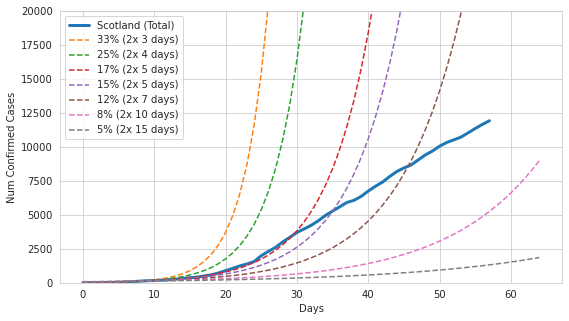

In [18]:
i = 8
max_days = len(df_cases) + 7
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3)
plt.plot(c*(1 + 0.33) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='33% (2x 3 days)')

plt.plot(c*(1 + 0.25) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='25% (2x 4 days)')
plt.plot(c*(1 + 0.17) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='17% (2x 5 days)')
plt.plot(c*(1 + 0.15) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 5 days)')
plt.plot(c*(1 + 0.12) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='12% (2x 7 days)')
plt.plot(c*(1 + 0.08) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='8% (2x 10 days)')
plt.plot(c*(1 + 0.05) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='5% (2x 15 days)')
plt.legend()
plt.ylim(0, 20000)
plt.xlabel('Days')
plt.ylabel('Num Confirmed Cases')

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


Text(0, 0.5, 'Num Confirmed Cases')

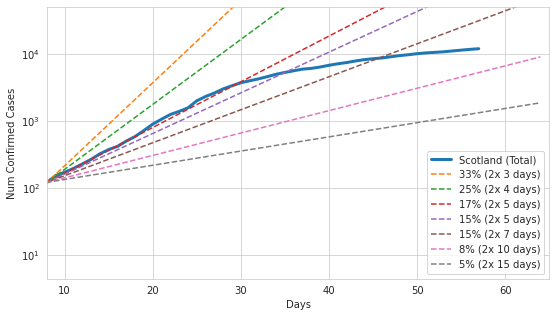

In [19]:
i = 8
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3, logy=True)
plt.plot(c*(1 + 0.33) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='33% (2x 3 days)')

plt.plot(c*(1 + 0.25) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='25% (2x 4 days)')
plt.plot(c*(1 + 0.17) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='17% (2x 5 days)')
plt.plot(c*(1 + 0.15) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 5 days)')
plt.plot(c*(1 + 0.12) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='15% (2x 7 days)')
plt.plot(c*(1 + 0.08) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='8% (2x 10 days)')
plt.plot(c*(1 + 0.05) ** (np.arange(0, max_days, 1)-i), linestyle='--', label='5% (2x 15 days)')
plt.legend()
plt.ylim(0, 50000)
plt.xlim(i, max_days)
plt.xlabel('Days')
plt.ylabel('Num Confirmed Cases')

In [20]:
with pm.Model() as model_scotland:
    
    ### Intercepts ###
    b = pm.Normal('b', 10, 5)
    
    
    ### Slopes ###
    a = pm.Normal('a', 1.12, 0.5)
    
    ### Error ###
    sigma = pm.HalfCauchy('sigma', 50.)
    
    ### Likelihood for Each Region ###
    cases = df_cases['Scotland (Total)'].values[10:]
        
    # From Twieki:
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pm.Data('x_data',
                np.arange(10, max_num_days, 1))
    confirmed = pm.Data('y_data',
                        cases)

    # Likelihood
    pm.NegativeBinomial(
        'Scotland (Total)',
        (b * a ** (x-8)), # Exponential regression
        sigma,
        observed=confirmed)

In [21]:
with model_scotland:
    # Sample posterior
    trace_scotland = pm.sample(tune=1000, draws=2000, 
                               chains=2, cores=4, target_accept=0.9,
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, b]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:10<00:00, 593.67draws/s]


In [22]:
with model_scotland:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, max_days)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({'x_data': x_data})
    pm.set_data({'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_scotland, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:02<00:00, 79.82it/s]


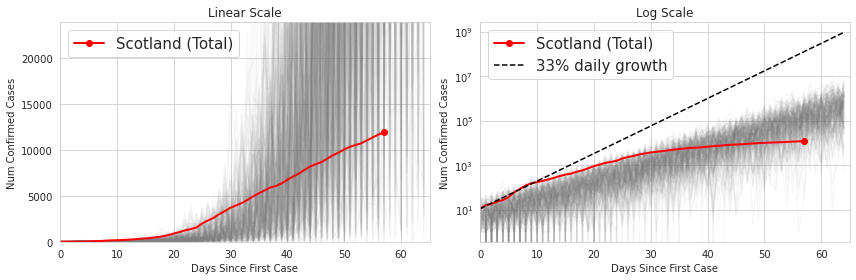

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))
r = 'Scotland (Total)'
y = df_cases[r].iloc[:].values

ax = axes[0]
for sim in post_pred[r]:
    ax.plot(sim, color='gray', alpha=0.05)
ax.plot(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
#ax.plot(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, max_days)
ax.set_ylim(0, 2*y.max())
ax.set_xlabel('Days Since First Case')
ax.set_ylabel('Num Confirmed Cases')
ax.set_title('Linear Scale')
ax.legend(fontsize=15)

ax = axes[1]
for sim in post_pred[r]:
    ax.semilogy(sim, color='gray', alpha=0.05)
ax.semilogy(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
ax.semilogy(y[0] * 1.33 ** np.arange(0, max_days), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, max_days)
ax.set_xlabel('Days Since First Case')
ax.set_ylabel('Num Confirmed Cases')
ax.set_title('Log Scale')
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

In [24]:
pm.stats.summary(trace_scotland)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,31.377,4.107,23.833,39.168,0.102,0.072,1620.0,1620.0,1616.0,1448.0,1.0
a,1.199,0.012,1.177,1.221,0.000,0.000,1626.0,1616.0,1773.0,1805.0,1.0
sigma,0.795,0.164,0.501,1.099,0.004,0.003,1599.0,1599.0,1568.0,1767.0,1.0


### Create the Model

In [40]:
with pm.Model() as model:
    
    ### Intercepts ###
    # Group mean
    #intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    intr_grp = 4.3
    # Group variance
    #intr_grp_sigma = pm.HalfNormal('intr_grp_sigma', 2.0)
    intr_grp_sigma = 2.0
    
    # Individual intercepts
    intr_ind = pm.Cauchy('intr_ind',
                          alpha=intr_grp,
                          beta=intr_grp_sigma,
                          shape=n_regions)
    
    
    ### Slopes ###
    # Group mean
    #slope_grp = pm.Normal('slope_grp', 1.13, 0.5)
    slope_grp = 1.13
    # Group variance
    #slope_grp_sigma = pm.HalfNormal('slope_grp_sigma', 0.5)
    slope_grp_sigma = 0.5
    
    # Individual slopes
    slope_ind = pm.Cauchy('slope_ind',
                          alpha=slope_grp,
                          beta=slope_grp_sigma,
                          shape=n_regions)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        starting_day = starting_days[region]
        cases_region = df_cases[region].values[starting_day:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(starting_day, max_num_days, 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [41]:
with model:
    # Sample posterior
    trace = pm.sample(tune=500, draws=1500, 
                      chains=2, cores=4, target_accept=0.9,
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, slope_ind, intr_ind]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:59<00:00, 22.27draws/s]


In [42]:
import pickle

In [43]:
#pickle.dump(trace, open('trace_1704.pk', 'wb'))
#pickle.dump(model, open('pymc_model_0904.pk', 'wb'))

In [44]:
with model:
    # Update data so that we get predictions into the future
    for i, r in enumerate(regions):
        #cases_region = df_cases[r].values[starting_days[r]:]
        x_data = np.arange(0, max_days)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({r + 'x_data': x_data})
        pm.set_data({r + 'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:27<00:00,  7.24it/s]


## Predicted Cases By Region

In [45]:
region_loc = {r: i for i,r in enumerate(regions)}

In [46]:
region_loc

{'Ayrshire and Arran': 0,
 'Borders': 1,
 'Dumfries and Galloway': 2,
 'Fife': 3,
 'Forth Valley': 4,
 'Grampian': 5,
 'Greater Glasgow and Clyde': 6,
 'Highland': 7,
 'Lanarkshire': 8,
 'Lothian': 9,
 'Shetland': 10,
 'Tayside': 11}

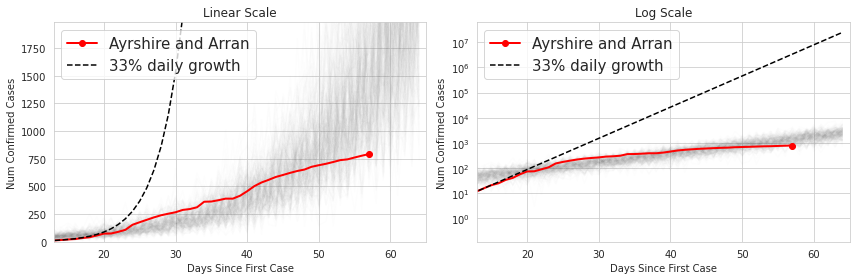

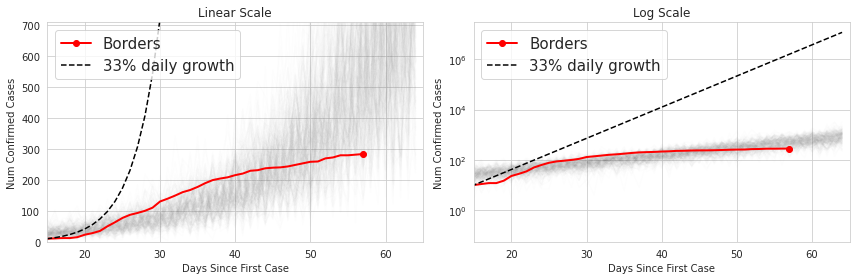

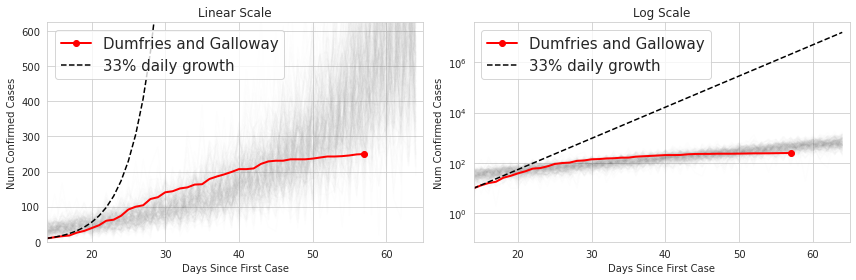

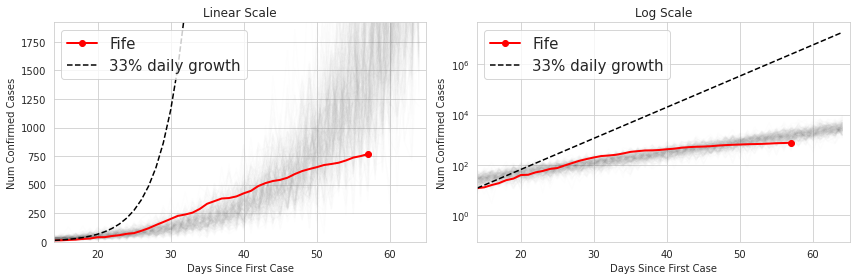

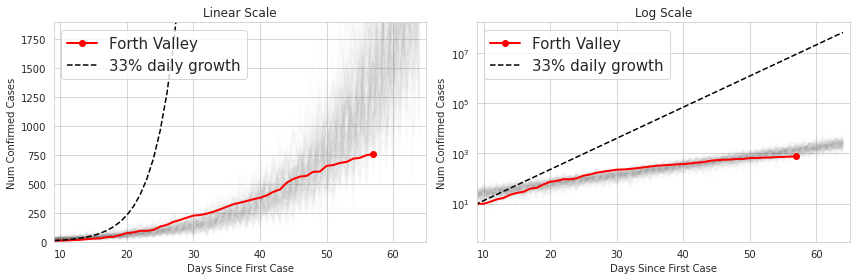

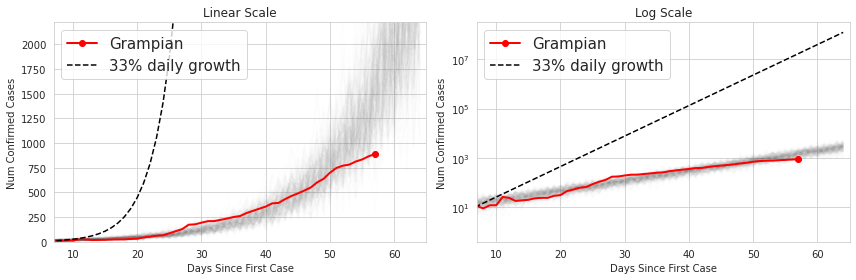

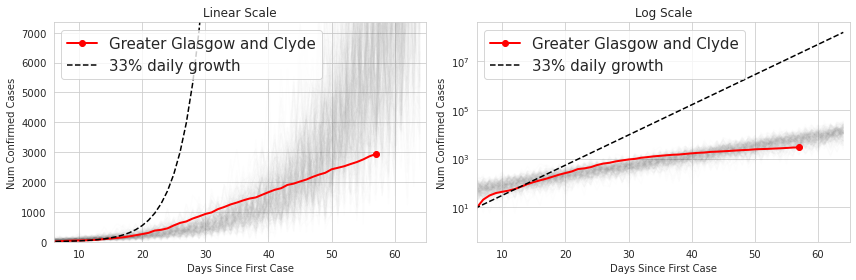

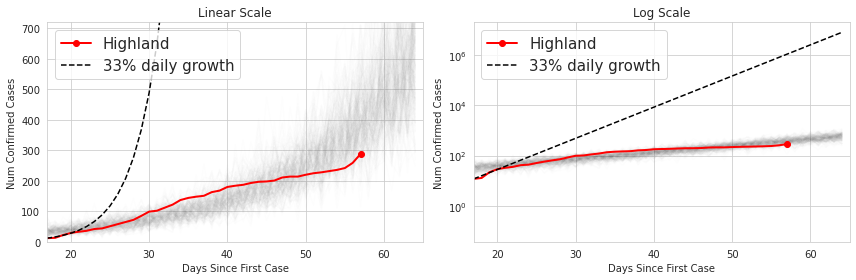

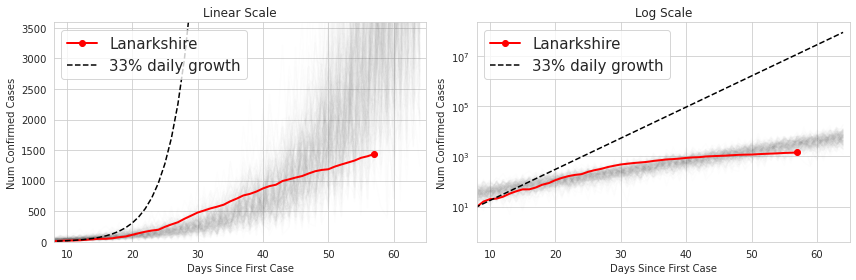

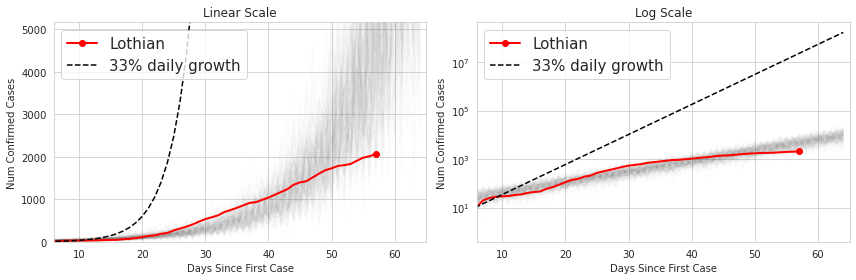

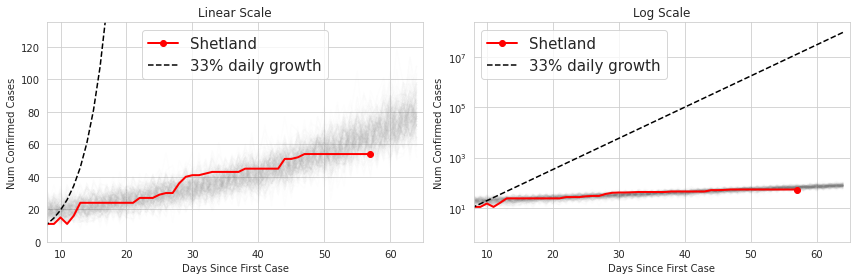

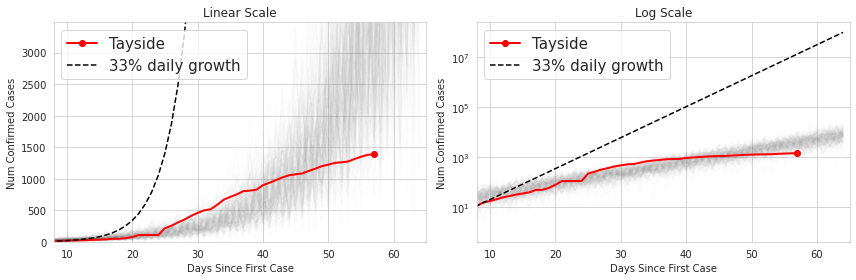

In [47]:
for r in regions:
    y = df_cases[r].iloc[:].values
    start = starting_days[r]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))

    ax = axes[0]
    for sim in post_pred[r]:
        ax.plot(sim, color='gray', alpha=0.01)
    ax.plot(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.plot(y[start] * 1.33 ** (np.arange(0, max_days)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, max_days)
    ax.set_ylim(0, 2.5*max(y))
    ax.set_ylabel('Num Confirmed Cases')
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Linear Scale')
    ax.legend(fontsize=15)

    ax = axes[1]
    for sim in post_pred[r]:
        ax.semilogy(sim, color='gray', alpha=0.01)
    ax.semilogy(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.semilogy(y[start] * 1.33 ** (np.arange(0, max_days)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, max_days)
    ax.set_xlabel('Days Since First Case')
    ax.set_ylabel('Num Confirmed Cases')
    ax.set_title('Log Scale')
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

## Posterior Growth Rates Per Region

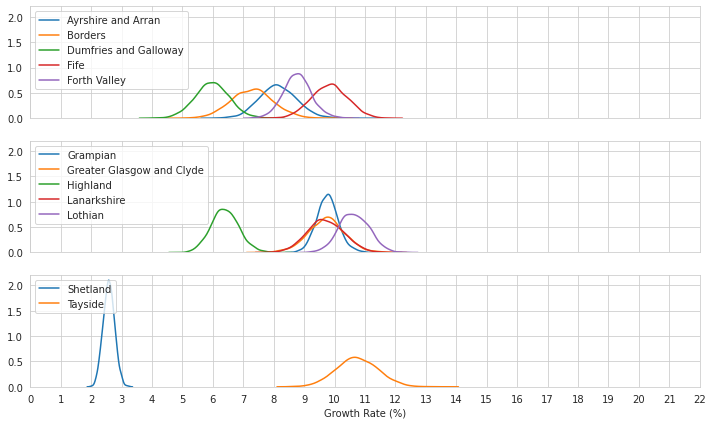

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharey=True, sharex=True)

for i in range(3):
    ax = axes[i]
    ax.grid()
    for r in regions[i*5: (i+1)*5]:
        sns.distplot((trace['slope_ind'][:, region_loc[r]] * 100 - 100), label=r, hist=False, ax=ax)
        ax.legend(loc=2)
        ax.grid()
    
ax.set_xlabel('Growth Rate (%)') 
ax.set_xticks(np.arange(0, 30))
ax.set_xlim(0, 22)
ax.grid()
plt.show()

Confidence intervals of growth rates for each region.

(Orkney and Western Isles ommitted due to lack of data)

In [49]:
for r in regions:
    print(f"{r} : \t{np.mean(trace['slope_ind'][:, region_loc[r]]):.6}  {pm.stats.hpd(trace['slope_ind'][:, region_loc[r]])}")

Ayrshire and Arran : 	1.08143  [1.07051016 1.09332412]
Borders : 	1.07294  [1.06051699 1.08631452]
Dumfries and Galloway : 	1.0598  [1.04915784 1.07059762]
Fife : 	1.09835  [1.08686668 1.10877723]
Forth Valley : 	1.08778  [1.07883553 1.09651976]
Grampian : 	1.09771  [1.09094788 1.10463575]
Greater Glasgow and Clyde : 	1.09731  [1.08598844 1.1086167 ]
Highland : 	1.06403  [1.05513338 1.07235947]
Lanarkshire : 	1.09705  [1.08596321 1.10825037]
Lothian : 	1.10647  [1.0974245  1.11574487]
Shetland : 	1.02587  [1.02223144 1.02929069]
Tayside : 	1.10744  [1.09504683 1.12043931]


In [50]:
pm.stats.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intr_ind[0],17.662,3.721,11.121,24.399,0.071,0.054,2726.0,2371.0,3081.0,1953.0,1.0
intr_ind[1],10.383,2.553,5.964,15.245,0.050,0.038,2635.0,2287.0,2968.0,1953.0,1.0
intr_ind[2],16.639,3.378,10.542,22.962,0.066,0.049,2653.0,2379.0,2916.0,1733.0,1.0
intr_ind[3],7.932,1.629,5.172,10.968,0.030,0.022,2973.0,2646.0,3296.0,1884.0,1.0
intr_ind[4],11.965,1.807,8.751,15.486,0.030,0.022,3625.0,3446.0,3859.0,2088.0,1.0
intr_ind[5],7.539,0.885,5.939,9.250,0.015,0.011,3539.0,3327.0,3639.0,2108.0,1.0
intr_ind[6],35.256,6.752,24.230,49.348,0.130,0.099,2700.0,2309.0,3081.0,1547.0,1.0
intr_ind[7],11.792,1.971,8.051,15.359,0.034,0.024,3424.0,3240.0,3451.0,2009.0,1.0
intr_ind[8],17.608,3.365,11.511,23.993,0.062,0.046,2964.0,2662.0,3087.0,2101.0,1.0
intr_ind[9],15.477,2.364,11.278,20.060,0.042,0.031,3125.0,2914.0,3282.0,2008.0,1.0


## Model Diagnostics

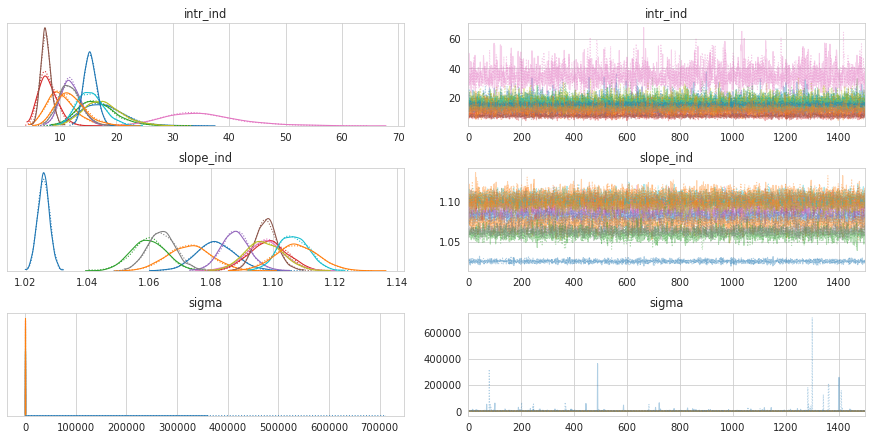

In [51]:
az.plot_trace(trace, compact=True);

In [52]:
19116 + 3000 * 20

79116